In [1]:
import pandas as pd

tweet_data = pd.read_csv('../processing/cleaned_tweet_data.csv')
user_data = pd.read_csv('../processing/cleaned_user_data.csv')

In [2]:
tweet_data.columns

Index(['tweet_id', 'company', 'date', 'username', 'text', 'replies', 'reposts',
       'likes', 'bookmarks', 'views', 'comment_count', 'total_engagement',
       'main_sentiment', 'avg_comment_sentiment'],
      dtype='object')

In [3]:
user_data.columns

Index(['company', 'username', 'text', 'total_comments', 'total_replies',
       'total_likes', 'sentiments', 'avg_sentiment'],
      dtype='object')

In [4]:
tweet_data['date'].value_counts()

date
2025-04-14    45
2025-04-11    45
2025-04-09    44
2025-04-15    42
2025-04-16    39
2025-04-10    36
2025-04-18    31
2025-04-17    29
2025-04-13    23
2025-04-12    20
Name: count, dtype: int64

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd

# Load the tokenizer and model
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Load your dataset
df = pd.read_csv("../processing/cleaned_user_data.csv")

# Tokenize the text
def predict_sentiment(text):
    text = str(text)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    sentiment = torch.argmax(probabilities, dim=1).item()
    return "POSITIVE" if sentiment == 1 else "NEGATIVE", probabilities[0][sentiment].item()

# Test the function with a sample text
sample_text = "I love programming!"
print(predict_sentiment(sample_text))

# Apply sentiment prediction
df["bert_sentiment"], df["bert_score"] = zip(*df["text"].apply(predict_sentiment))

# Display results
df[["text", "bert_sentiment", "bert_score"]].head()

('POSITIVE', 0.9998701810836792)


,text,bert_sentiment,bert_score
0,i want this i want this i want this i want this,POSITIVE,0.995781
1,oneplus t pink oneplus t pink oneplus t pink o...,NEGATIVE,0.990809
2,cant go wrong with the classics whats your pic...,NEGATIVE,0.996509
3,single take i wonder why our teachers would do...,NEGATIVE,0.996689
4,can you guess which is the lucky charm can you...,POSITIVE,0.999324


In [20]:
df[["text", "bert_sentiment", "bert_score"]].head()

,text,bert_sentiment,bert_score
0,i want this i want this i want this i want this,POSITIVE,0.995781
1,oneplus t pink oneplus t pink oneplus t pink o...,NEGATIVE,0.990809
2,cant go wrong with the classics whats your pic...,NEGATIVE,0.996509
3,single take i wonder why our teachers would do...,NEGATIVE,0.996689
4,can you guess which is the lucky charm can you...,POSITIVE,0.999324


In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assume df has BERT sentiment columns already
df['sentiment_numeric'] = df['bert_sentiment'].map({'NEGATIVE': -1, 'POSITIVE': 1})  # or 0 and 1

# Encode 'company' if needed
le = LabelEncoder()
df['company_encoded'] = le.fit_transform(df['company'])

# Final feature set
features = df[['company_encoded', 'total_comments', 'total_replies',
               'total_likes', 'sentiment_numeric', 'bert_score']]


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

df['text'] = df['text'].astype(str)  # Ensure text is string type

# Convert to bag-of-words
vectorizer = CountVectorizer(max_df=0.9, min_df=5, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df['text'])

# LDA
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)  # Choose number of topics
lda_output = lda_model.fit_transform(doc_term_matrix)


In [22]:
import numpy as np

# Add dominant topic
df['topic'] = np.argmax(lda_output, axis=1)

# Or add full topic distribution
for i in range(lda_output.shape[1]):
    df[f'topic_{i}'] = lda_output[:, i]

In [24]:
features = df[['company_encoded', 'total_comments', 'total_replies',
               'total_likes', 'sentiment_numeric', 'bert_score',
               'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4']]

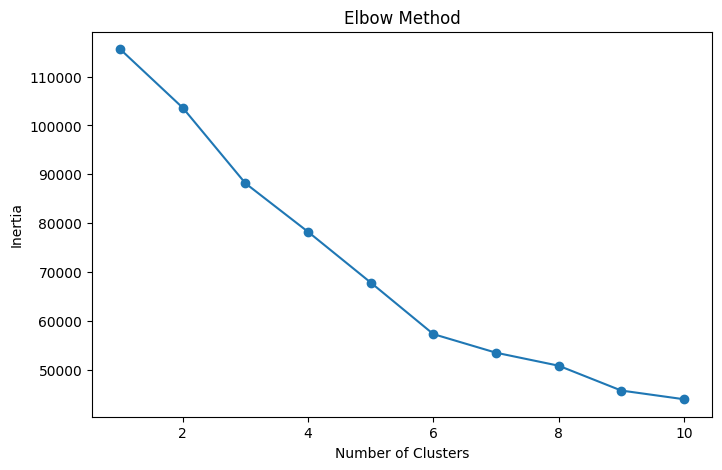

In [25]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Elbow Method
inertia = []
k_range = range(1, 11)  # Test 1 to 10 clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

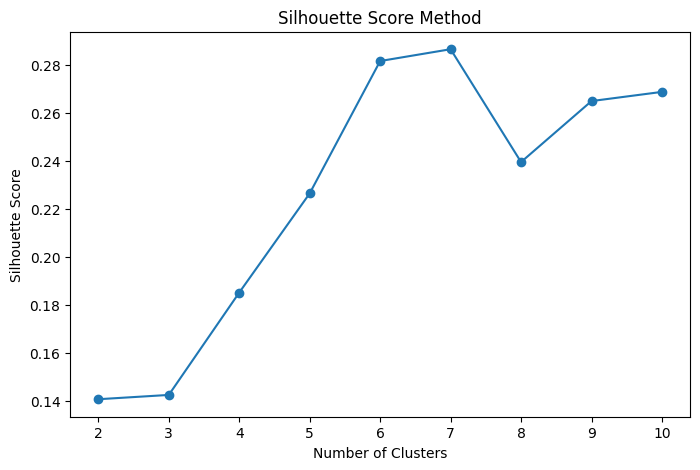

In [26]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_range = range(2, 11)  # Test 2 to 10 clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Plot the Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title("Silhouette Score Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

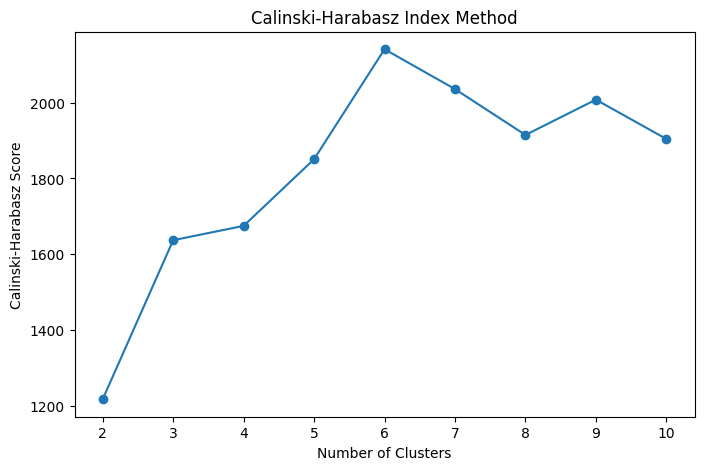

In [27]:
from sklearn.metrics import calinski_harabasz_score

ch_scores = []
k_range = range(2, 11)  # Test 2 to 10 clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = calinski_harabasz_score(X_scaled, labels)
    ch_scores.append(score)

# Plot the Calinski-Harabasz Scores
plt.figure(figsize=(8, 5))
plt.plot(k_range, ch_scores, marker='o')
plt.title("Calinski-Harabasz Index Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Calinski-Harabasz Score")
plt.show()

In [28]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Cluster (let's say 3 segments)
kmeans = KMeans(n_clusters=6, random_state=42)
df['segment'] = kmeans.fit_predict(X_scaled)


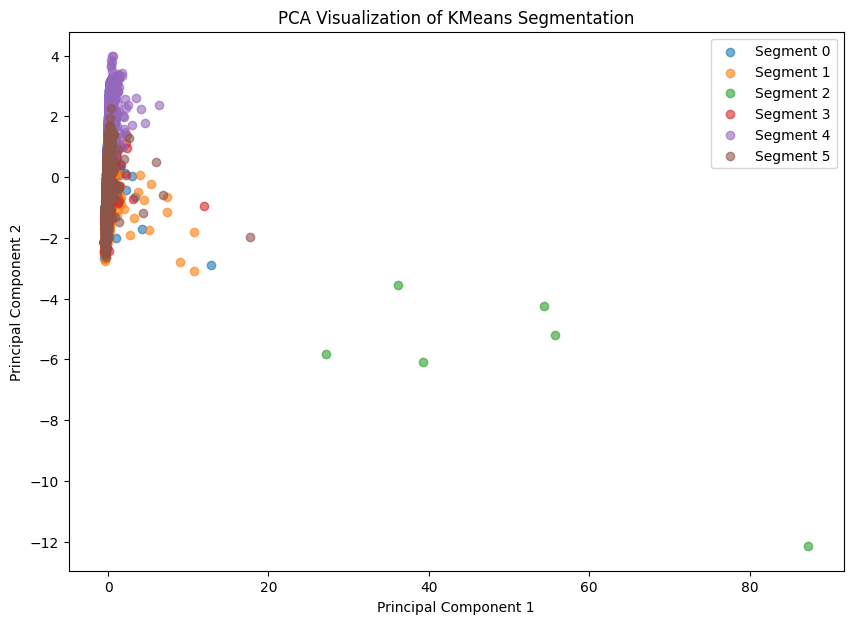

In [29]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

# Perform PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a scatter plot
plt.figure(figsize=(10, 7))
for segment in range(kmeans.n_clusters):
    plt.scatter(X_pca[df['segment'] == segment, 0], X_pca[df['segment'] == segment, 1], label=f"Segment {segment}", alpha=0.6)

plt.title("PCA Visualization of KMeans Segmentation")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

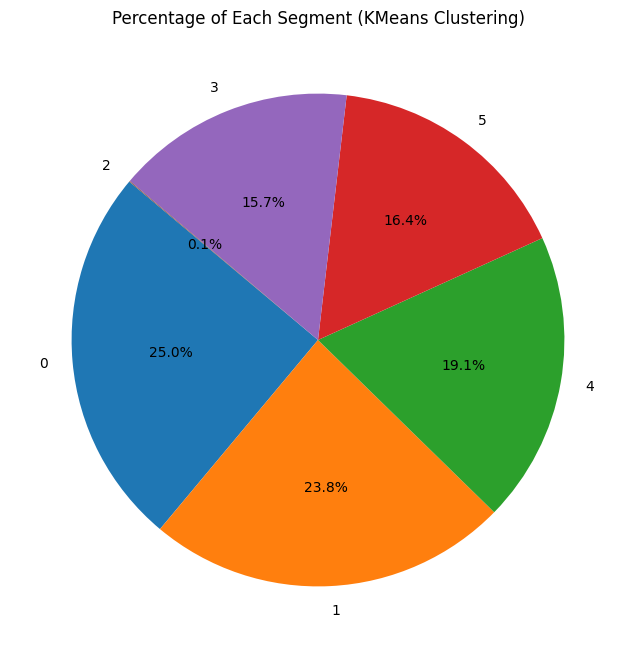

In [ ]:
import matplotlib.pyplot as plt

# Count the occurrences of each segment
segment_counts = df['segment'].value_counts()

#
plt.figure(figsize=(8, 8))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab10.colors)
plt.title("Percentage of Each Segment (KMeans Clustering)")
plt.show()

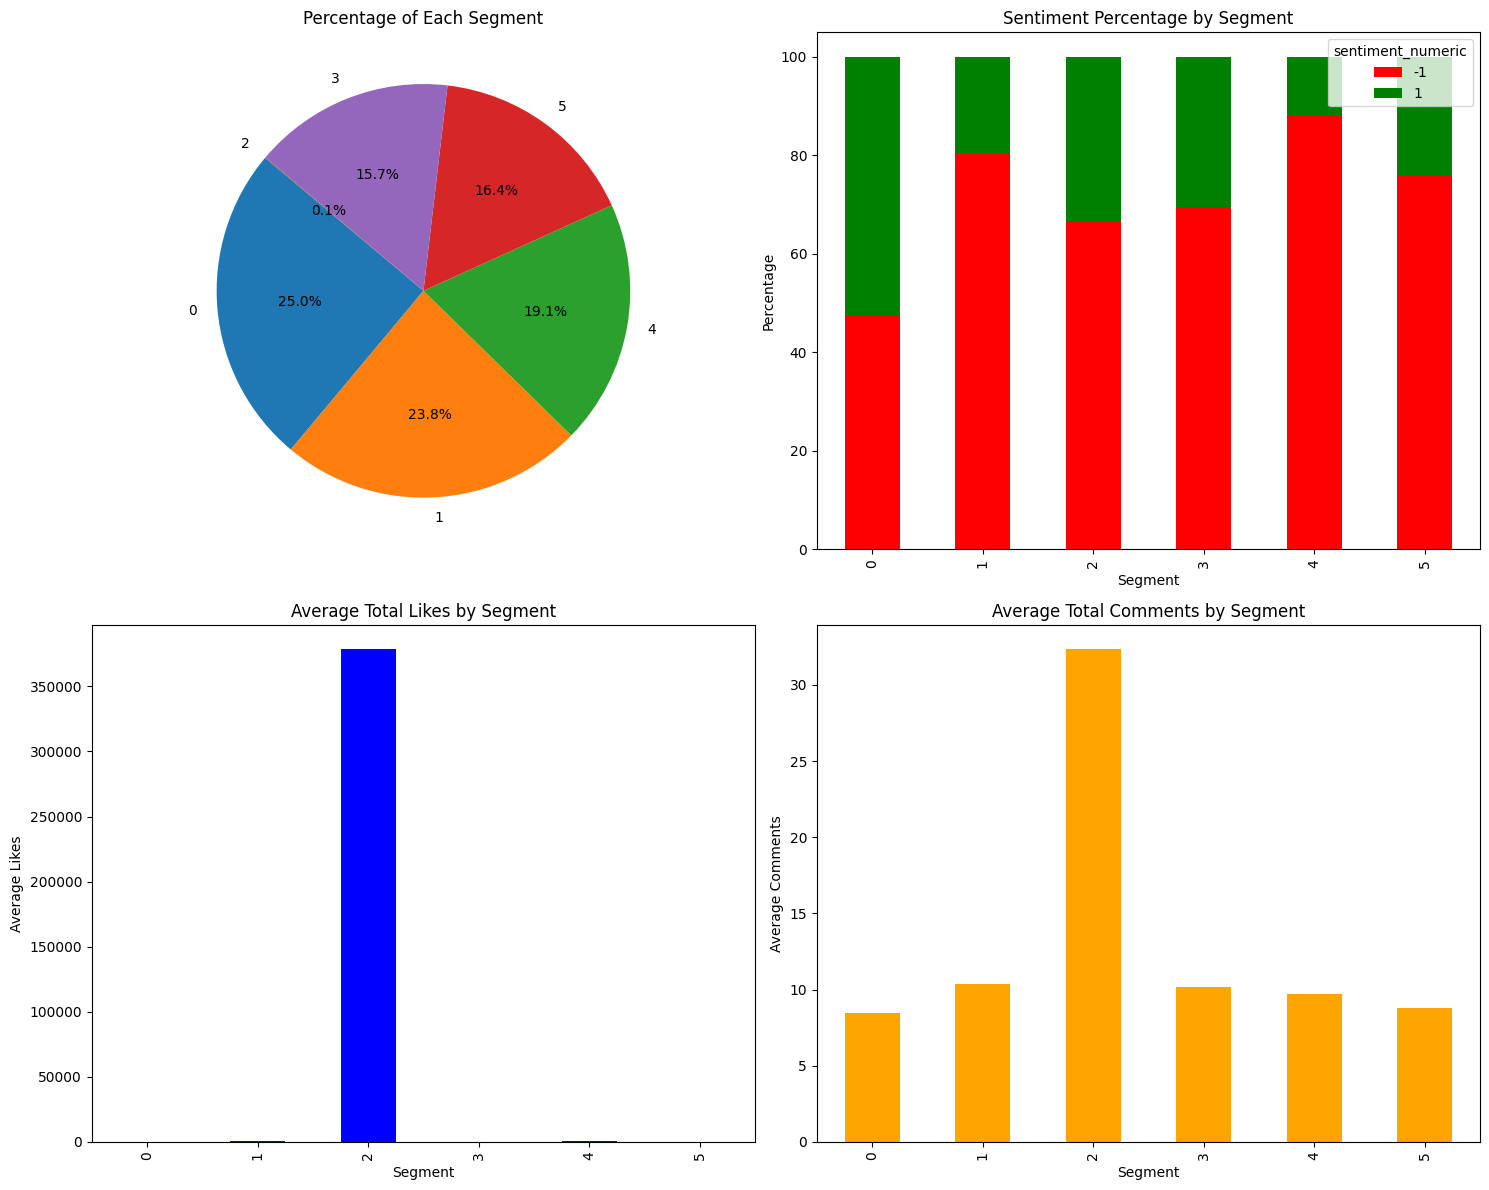

In [31]:
import matplotlib.pyplot as plt

# Calculate the percentage of each segment
segment_counts = df['segment'].value_counts()
segment_percentages = segment_counts / segment_counts.sum() * 100

# Calculate the percentage of positive and negative sentiment for each segment
sentiment_percentages = df.groupby(['segment', 'sentiment_numeric']).size().unstack(fill_value=0)
sentiment_percentages = sentiment_percentages.div(sentiment_percentages.sum(axis=1), axis=0) * 100

# Calculate the average total likes and comments for each segment
avg_total_likes = df.groupby('segment')['total_likes'].mean()
avg_total_comments = df.groupby('segment')['total_comments'].mean()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Pie chart for segment percentages
axes[0, 0].pie(segment_percentages, labels=segment_percentages.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab10.colors)
axes[0, 0].set_title("Percentage of Each Segment")

# Bar chart for sentiment percentages
sentiment_percentages.plot(kind='bar', stacked=True, ax=axes[0, 1], color=['red', 'green'])
axes[0, 1].set_title("Sentiment Percentage by Segment")
axes[0, 1].set_ylabel("Percentage")
axes[0, 1].set_xlabel("Segment")

# Bar chart for average total likes
avg_total_likes.plot(kind='bar', ax=axes[1, 0], color='blue')
axes[1, 0].set_title("Average Total Likes by Segment")
axes[1, 0].set_ylabel("Average Likes")
axes[1, 0].set_xlabel("Segment")

# Bar chart for average total comments
avg_total_comments.plot(kind='bar', ax=axes[1, 1], color='orange')
axes[1, 1].set_title("Average Total Comments by Segment")
axes[1, 1].set_ylabel("Average Comments")
axes[1, 1].set_xlabel("Segment")

# Adjust layout
plt.tight_layout()
plt.show()

In [37]:
# Group data by company
company_groups = df.groupby('company')

# Dictionary to store segmented data for each company
segmented_data = {}

# Perform segmentation for each company
for company, group in company_groups:
    # Normalize the features for the current company
    X_scaled_company = scaler.fit_transform(group[features.columns])
    
    # Apply KMeans clustering (e.g., 6 clusters)
    kmeans_company = KMeans(n_clusters=6, random_state=42)
    group['segment'] = kmeans_company.fit_predict(X_scaled_company)
    
    # Store the segmented data
    segmented_data[company] = group

# Example: Access segmented data for a specific company
segmented_data['samsung'].head()

,company,username,text,total_comments,total_replies,total_likes,sentiments,avg_sentiment,bert_sentiment,bert_score,sentiment_numeric,company_encoded,segment,bertopic,topic,topic_0,topic_1,topic_2,topic_3,topic_4
0,samsung,viklibeva,i want this i want this i want this i want this,4,0,0,"[0.0, 0.0, 0.0, 0.0]",0.000000,POSITIVE,0.995781,1,2,4,-1,3,0.040414,0.040182,0.040384,0.838912,0.040107
1,samsung,stufflistings,oneplus t pink oneplus t pink oneplus t pink o...,4,260,1928,"[-0.1, -0.1, -0.1, -0.1]",-0.100000,NEGATIVE,0.990809,-1,2,0,-1,0,0.839237,0.040000,0.040000,0.040000,0.040762
2,samsung,nipunmarya,cant go wrong with the classics whats your pic...,4,300,988,"[-0.625, -0.625, -0.625, -0.625]",-0.625000,NEGATIVE,0.996509,-1,2,2,115,2,0.015538,0.015593,0.633443,0.015455,0.319971
3,samsung,StyleListings,single take i wonder why our teachers would do...,4,228,1144,"[-0.07142857142857142, -0.07142857142857142, -...",-0.071429,NEGATIVE,0.996689,-1,2,4,93,3,0.022718,0.022222,0.022598,0.910079,0.022382
4,samsung,CeliaKayo,can you guess which is the lucky charm can you...,4,164,432,"[0.3333333333333333, 0.3333333333333333, 0.333...",0.333333,POSITIVE,0.999324,1,2,0,101,0,0.937921,0.015385,0.015588,0.015661,0.015445


In [41]:
features = {}
for company in df['company'].unique():
    features[company] = segmented_data[company][['total_comments', 'total_replies',
                                                   'total_likes', 'sentiment_numeric', 'bert_score',
                                                   'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4']]

In [42]:
features['apple'].head()

,total_comments,total_replies,total_likes,sentiment_numeric,bert_score,topic_0,topic_1,topic_2,topic_3,topic_4
441,4,0,8,1,0.999729,0.040000,0.040000,0.040000,0.040000,0.840000
442,4,0,8,1,0.999874,0.040000,0.040000,0.040000,0.839999,0.040000
443,7,0,0,1,0.999882,0.013452,0.013335,0.946178,0.013336,0.013699
444,8,0,0,-1,0.999575,0.004898,0.652574,0.005004,0.332593,0.004931
445,56,60,118,-1,0.998680,0.118209,0.105018,0.386217,0.272657,0.117900


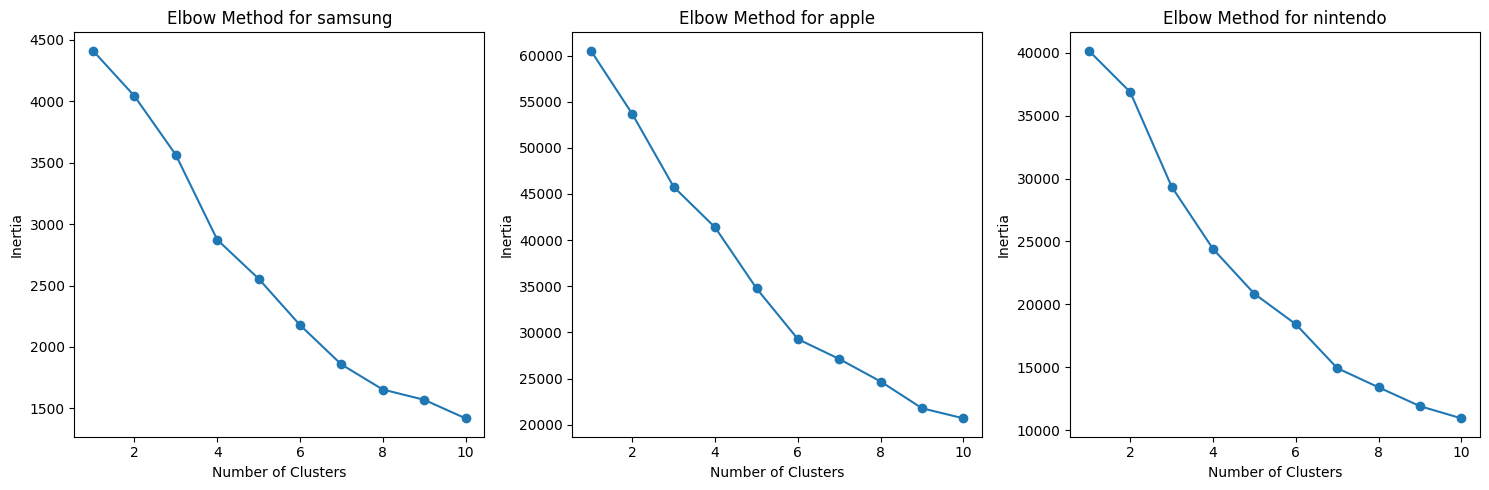

In [46]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(1, len(features), figsize=(15, 5))

# Iterate through each company in features
for ax, (company, data) in zip(axes, features.items()):
    # Normalize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)

    # Elbow Method
    inertia = []
    k_range = range(1, 11)  # Test 1 to 10 clusters
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)

    # Plot the Elbow Curve for the current company
    ax.plot(k_range, inertia, marker='o')
    ax.set_title(f"Elbow Method for {company}")
    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel("Inertia")

# Adjust layout
plt.tight_layout()
plt.show()


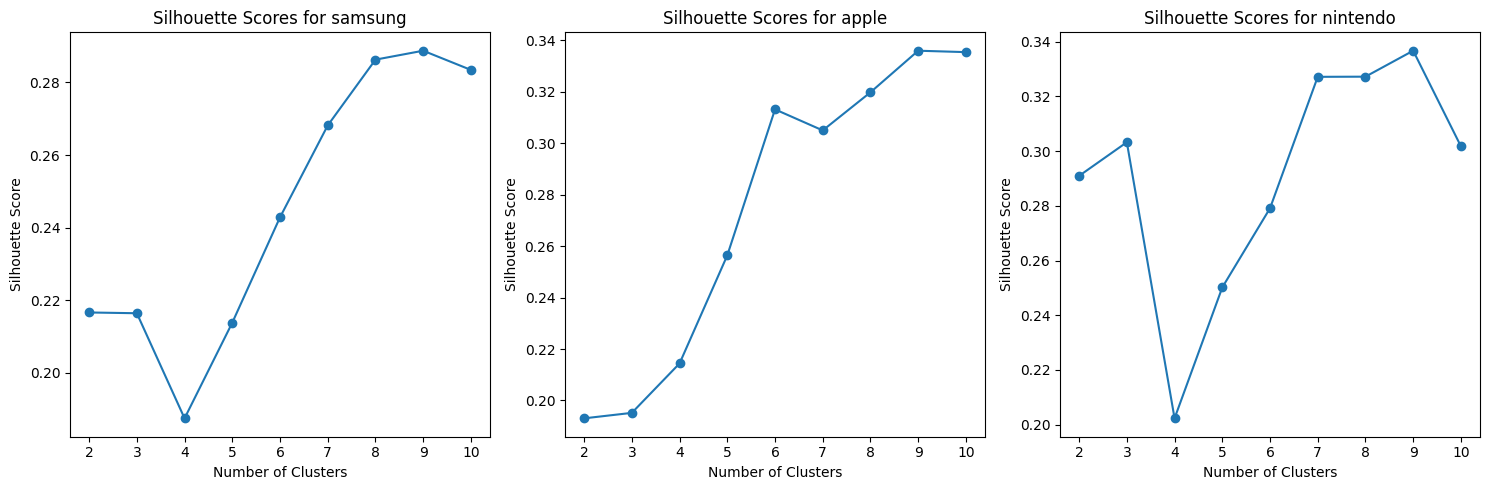

In [47]:
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(1, len(features), figsize=(15, 5))

# Iterate through each company in features
for ax, (company, data) in zip(axes, features.items()):
    # Normalize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)

    # Silhouette Scores
    silhouette_scores = []
    k_range = range(2, 11)  # Test 2 to 10 clusters
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        silhouette_scores.append(score)

    # Plot the Silhouette Scores for the current company
    ax.plot(k_range, silhouette_scores, marker='o')
    ax.set_title(f"Silhouette Scores for {company}")
    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel("Silhouette Score")

# Adjust layout
plt.tight_layout()
plt.show()

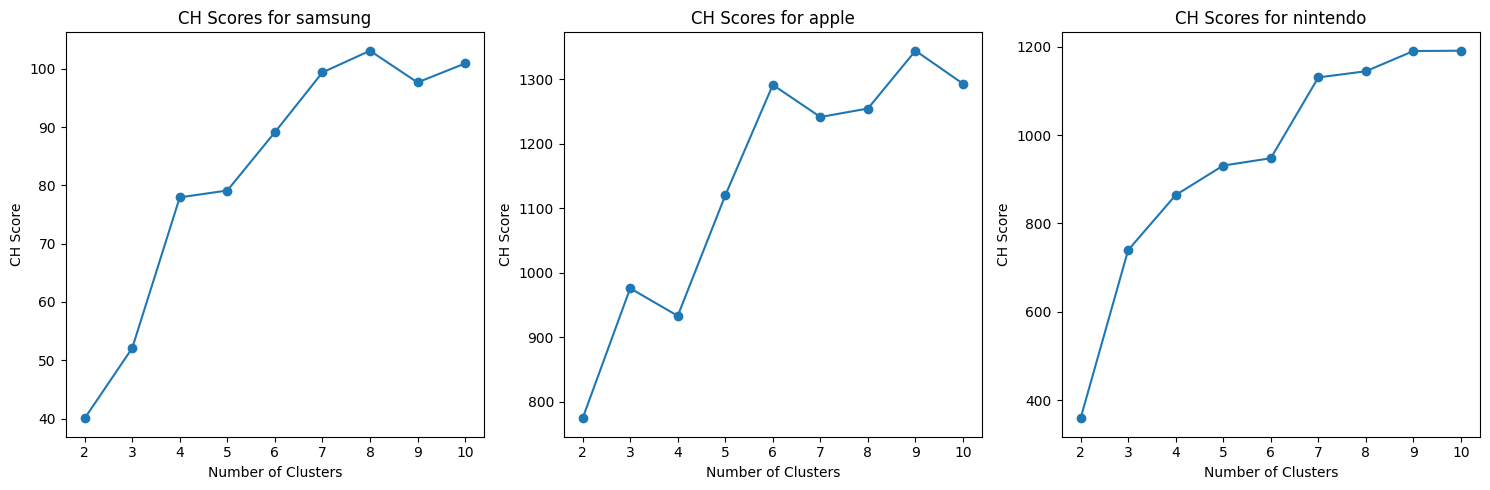

In [48]:
from sklearn.metrics import calinski_harabasz_score

import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(1, len(features), figsize=(15, 5))

# Iterate through each company in features
for ax, (company, data) in zip(axes, features.items()):
    # Normalize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)

    # Calinski-Harabasz Scores
    ch_scores = []
    k_range = range(2, 11)  # Test 2 to 10 clusters
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        score = calinski_harabasz_score(X_scaled, labels)
        ch_scores.append(score)

    # Plot the Calinski-Harabasz Scores for the current company
    ax.plot(k_range, ch_scores, marker='o')
    ax.set_title(f"CH Scores for {company}")
    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel("CH Score")

# Adjust layout
plt.tight_layout()
plt.show()

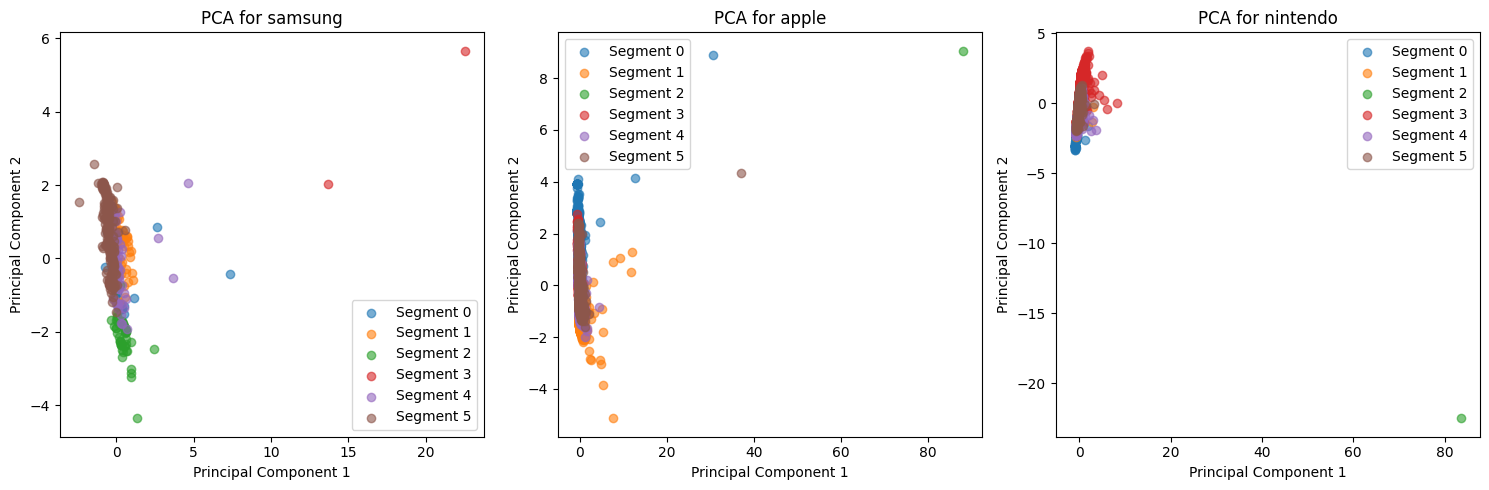

In [49]:
# Perform KMeans segmentation and plot PCA for each company
fig, axes = plt.subplots(1, len(features), figsize=(15, 5))

for ax, (company, data) in zip(axes, features.items()):
    # Normalize the data
    X_scaled_company = scaler.fit_transform(data)

    # Apply KMeans clustering (e.g., 6 clusters)
    kmeans_company = KMeans(n_clusters=6, random_state=42)
    labels = kmeans_company.fit_predict(X_scaled_company)

    # Perform PCA to reduce dimensions to 2D
    pca = PCA(n_components=2)
    X_pca_company = pca.fit_transform(X_scaled_company)

    # Scatter plot with PCA components and segment labels
    for segment in range(kmeans_company.n_clusters):
        ax.scatter(X_pca_company[labels == segment, 0], X_pca_company[labels == segment, 1], label=f"Segment {segment}", alpha=0.6)

    ax.set_title(f"PCA for {company}")
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

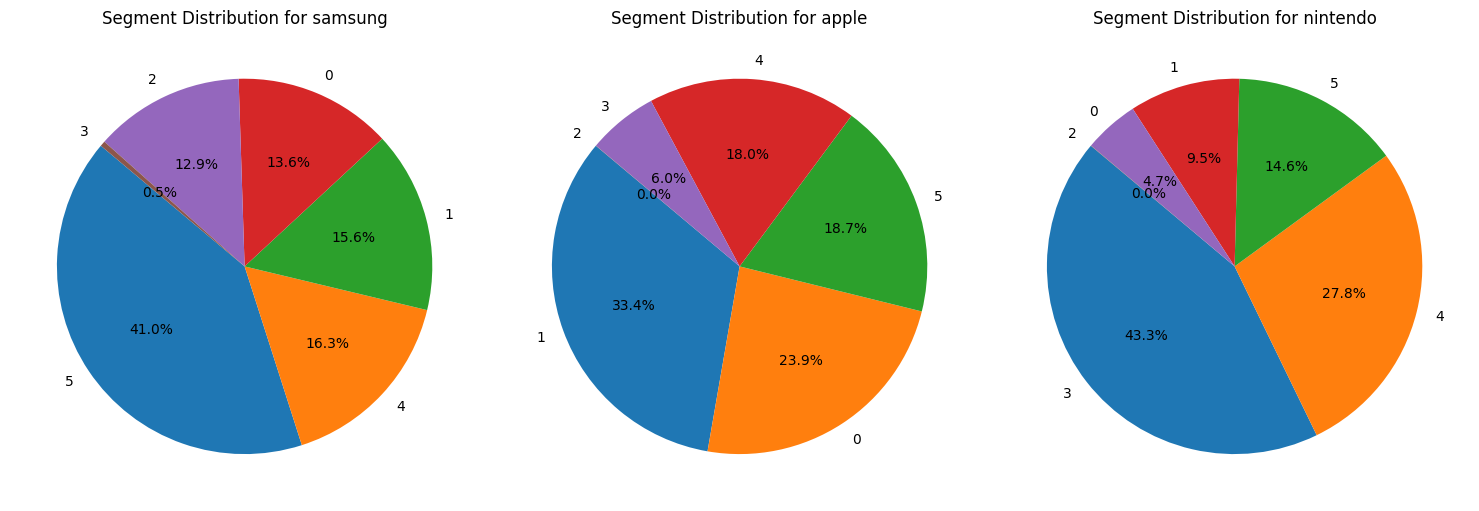

In [52]:
# Create subplots for pie charts
fig, axes = plt.subplots(1, len(features), figsize=(15, 5))

# Iterate through each company in features
for ax, (company, data) in zip(axes, features.items()):
    
    # Normalize the data
    X_scaled_company = scaler.fit_transform(data)

    # Apply KMeans clustering (e.g., 6 clusters)
    kmeans_company = KMeans(n_clusters=6, random_state=42)
    labels = kmeans_company.fit_predict(X_scaled_company)

    # Count the occurrences of each segment
    segment_counts = pd.Series(labels).value_counts()
    segment_percentages = segment_counts / segment_counts.sum() * 100

    # Plot pie chart
    ax.pie(segment_percentages, labels=segment_percentages.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab10.colors)
    ax.set_title(f"Segment Distribution for {company}")

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Elbow Method
inertia = []
k_range = range(1, 11)  # Test 1 to 10 clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

# Or simpely using Bert to train it for sentiment prediction

#### Maybe adding graph visualizaation of the customers

In [ ]:
#